# Cleaned Data

In [1]:
import pandas as pd

df = pd.read_csv('fraudClean.csv')

print(df.head().to_string())

print(df.shape)

   merchant  category    amt  job  age_at_transaction    distance  transactions_last_hour  transactions_last_day  is_fraud
0       293         8   7.27  246                  32  127.606239                     1.0                    1.0         0
1        43         2  52.94  246                  32  110.308921                     1.0                    2.0         0
2       399         2  82.08  246                  32   21.787261                     2.0                    3.0         0
3       126         7  34.79  246                  32   87.204215                     1.0                    4.0         0
4        41         6  27.18  246                  32   74.212965                     2.0                    4.0         0
(1296675, 9)


# Split Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

X = df.drop('is_fraud', axis=1)
Y = df['is_fraud']

smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42, stratify = Y_resampled)

# Anomaly Detection

In [3]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.02, random_state=42)


y_train_iforest_pred = isolation_forest.fit_predict(X_train)

y_train_iforest_anomaly = pd.Series(y_train_iforest_pred).map({1: 0, -1: 1}) 

X_train_combined = pd.DataFrame(X_train, columns=X.columns)

X_train_combined['isolation_forest'] = isolation_forest.predict(X_train)
X_train_combined['isolation_forest'] = X_train_combined['isolation_forest'].map({1: 0, -1: 1})

X_test_combined = pd.DataFrame(X_test, columns=X.columns)

X_test_combined['isolation_forest'] = isolation_forest.predict(X_test)
X_test_combined['isolation_forest'] = X_test_combined['isolation_forest'].map({1: 0, -1: 1})


In [4]:
print(X_train_combined.head().to_string())

   merchant  category       amt       job  age_at_transaction  distance  transactions_last_hour  transactions_last_day  isolation_forest
0 -0.817640 -1.235195 -0.631637 -1.370642           -0.972536  1.151736               -0.628809              -1.170826                 0
1 -0.741378 -0.703038 -0.538994 -1.686486           -1.268085 -0.408556               -0.628809              -0.787011                 0
2 -0.004181  1.425590 -0.787726  1.314028           -1.149865  0.376839               -0.628809               0.748249                 0
3 -0.883733 -0.170881 -0.737879  1.658584           -0.499659  0.409874               -0.439043               0.549526                 0
4  1.160083 -0.703038 -0.039060 -0.552320           -0.736097 -0.855216               -0.628809              -0.231256                 0


# Logistics Regression

In [5]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_combined, Y_train)

# Predictions
Y_pred_log_reg = log_reg.predict(X_test_combined)
log_accuracy = accuracy_score(Y_test, Y_pred_log_reg)
print(classification_report(Y_test, Y_pred_log_reg))
print("Test accuracy: ", log_accuracy)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86    257834
           1       0.90      0.79      0.84    257834

    accuracy                           0.85    515668
   macro avg       0.86      0.85      0.85    515668
weighted avg       0.86      0.85      0.85    515668

Test accuracy:  0.8532195133302822


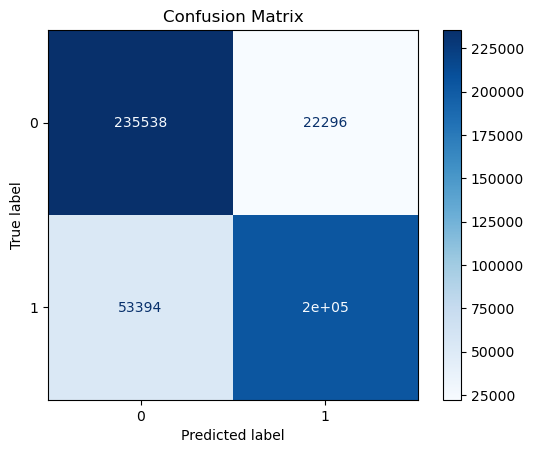

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, Y_pred_log_reg)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_combined, Y_train)

# Predictions
y_pred_dt = decision_tree.predict(X_test_combined)
print("Decision Tree:")
print(classification_report(Y_test, y_pred_dt))

tree_accuracy = accuracy_score(Y_test, y_pred_dt)

print(tree_accuracy)


Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       1.00      1.00      1.00    257834

    accuracy                           1.00    515668
   macro avg       1.00      1.00      1.00    515668
weighted avg       1.00      1.00      1.00    515668

0.996278613371394


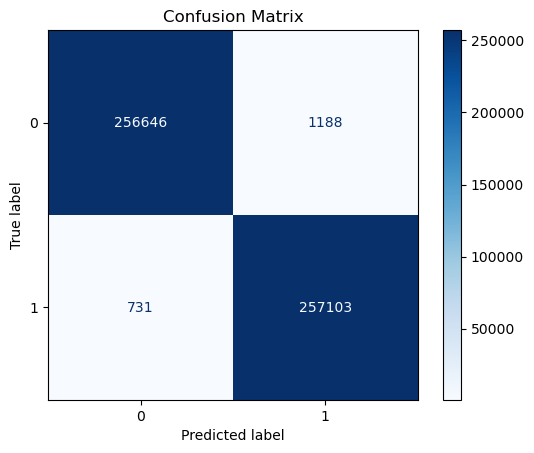

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(Y_test, y_pred_dt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# MLP Classifier

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

MLP_model = MLPClassifier(hidden_layer_sizes=(64,64,64), activation = 'tanh', solver='adam', max_iter=10, random_state=42)

MLP_model.fit(X_train, Y_train)

Y_pred = MLP_model.predict(X_test)

MLP_accuracy = accuracy_score(Y_test, Y_pred)

print("Test accuracy: ", MLP_accuracy)
print(classification_report(Y_test, Y_pred))

c:\Users\Joenathan\anaconda3\envs\AI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Test accuracy:  0.9753155130820605
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    257834
           1       0.98      0.97      0.98    257834

    accuracy                           0.98    515668
   macro avg       0.98      0.98      0.98    515668
weighted avg       0.98      0.98      0.98    515668



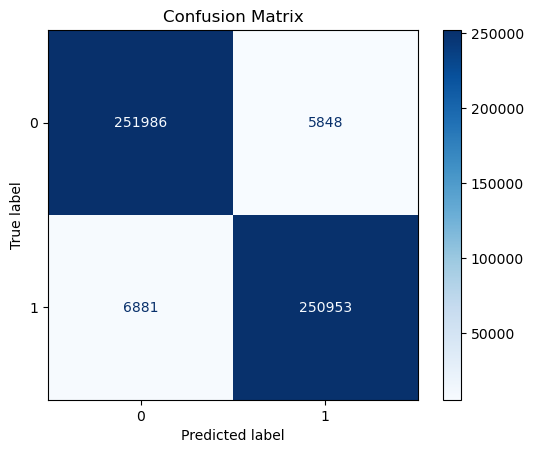

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_combined, Y_train)

y_pred_rf = random_forest.predict(X_test_combined)

rf_accuracy = accuracy_score(Y_test, y_pred_rf)

print(rf_accuracy)


0.998425343438026


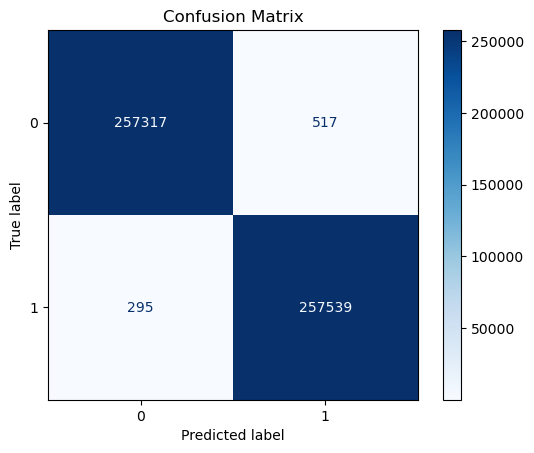

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Ensemble Model

In [13]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('DT', decision_tree),
    ('MLP', MLP_model),
    ("RF", random_forest),
], voting='soft')

ensemble.fit(X_train_combined, Y_train)

y_pred_ensemble = ensemble.predict(X_test_combined)
print(classification_report(Y_test, y_pred_ensemble))
print(accuracy_score(Y_test, y_pred_ensemble))

c:\Users\Joenathan\anaconda3\envs\AI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       1.00      1.00      1.00    257834

    accuracy                           1.00    515668
   macro avg       1.00      1.00      1.00    515668
weighted avg       1.00      1.00      1.00    515668

0.9975119650627924


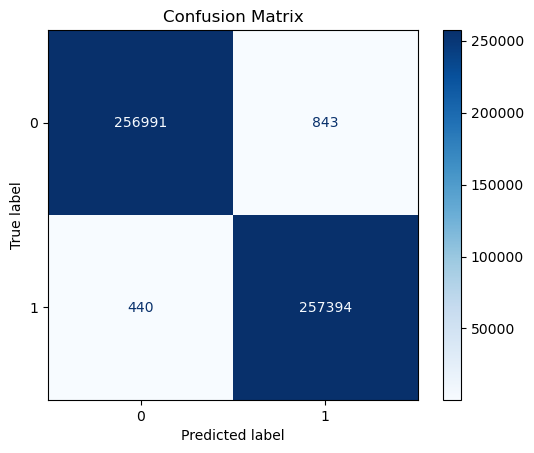

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred_ensemble)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()